# Quantization

La quantization consiste à discrétiser les paramètres d'un réseau de neurones afin de réduire l'espace mémoire et les temps de calculer en contrepartie d'une perte de performance. Comment estimer ces paramètres pour minimiser la perte ?

## Une matrice de coefficients

On les prend d'un modèle de deep learning [MobileNet](https://github.com/onnx/models/tree/main/vision/classification/mobilenet).

In [1]:
import os
import urllib

url = "https://github.com/onnx/models/raw/main/vision/classification/mobilenet/model/mobilenetv2-12.onnx"
destination = "mobilenetv2-12.onnx"

if not os.path.exists(destination) or os.stat(destination).st_size < 10000:
    print(f"download {destination!r}")
    g = urllib.request.urlopen(url)
    with open(destination, 'wb') as f:
        f.write(g.read())
    print("done")
else:
    print(f"already downloaded {destination!r}")
print(f"model size {os.stat(destination).st_size} bytes")

already downloaded 'mobilenetv2-12.onnx'
model size 13964571 bytes


In [2]:
from onnx import load

with open(destination, "rb") as f:
    onx = load(f)
    print(f"model size: {len(onx.SerializeToString())}")

model size: 13964571


On prend une des plus grandes matrices de coefficients.

In [17]:
initializers = []
for init in onx.graph.initializer:
    initializers.append((len(init.SerializeToString()), init.name, init))

initializers.sort()

for init in initializers[-5:]:
    print(init[:2])

(614421, '616')
(614421, '619')
(1228821, '625')
(1638421, '628')
(5120034, 'classifier.1.weight')


In [20]:
from onnx.numpy_helper import to_array

coef = to_array(initializers[-4][-1])
coef.shape, coef.dtype

((960, 160, 1, 1), dtype('float32'))

## Distributions

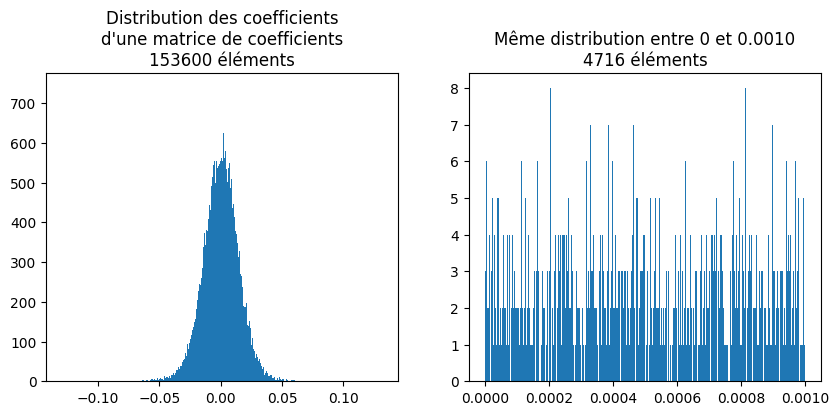

In [23]:
import matplotlib.pyplot as plt

cf = coef.ravel()
cf01 = cf[(cf >= 0) & (cf <= 0.001)]

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(cf, bins=2048)
axs[0].set_title(f"Distribution des coefficients\nd'une matrice de coefficients\n{cf.size} éléments")
axs[1].hist(cf01, bins=2048)
axs[1].set_title(f"Même distribution entre 0 et {cf01.max():.4f}\n{cf01.size} éléments");

Et maintenant la distribution des float 8.

In [26]:
import numpy
from onnx.numpy_helper import float8e4m3_to_float32

float8 = [float8e4m3_to_float32(i) for i in range(0, 256)]
no_nan8 = [f for f in float8 if not numpy.isnan(f)]
len(no_nan8)

254

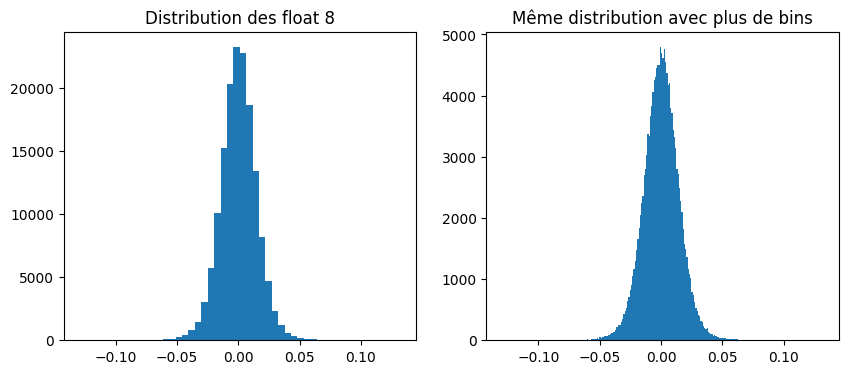

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(cf, bins=50)
axs[0].set_title("Distribution des float 8")
axs[1].hist(cf, bins=254)
axs[1].set_title("Même distribution avec plus de bins");